***MONTAGE DE GOOGLE DRIVE ET CHARGEMENT DU MODÈLE***


In [1]:
from google.colab import drive  # Importation de la bibliothèque pour monter Google Drive dans Colab
drive.mount('/content/drive', force_remount=True)  # Montage du disque Google Drive avec une option de forçage

# Extraction de l'archive du dataset dans la session Colab
# Chemin mis à jour
!unzip -q "/content/drive/MyDrive/Data/plantvillage_dataset/color_split.zip" -d "/content/"  # Décompression

Mounted at /content/drive


***IMPORTATION DES LIBRAIRIES***


In [2]:
import os  # Bibliothèque pour les interactions avec le système de fichiers
import numpy as np  # Bibliothèque pour les calculs numériques
import matplotlib.pyplot as plt  # Bibliothèque pour la visualisation de données
# Permet d'afficher les graphiques directement dans le notebook
%matplotlib inline
import seaborn as sns  # Bibliothèque pour des visualisations statistiques
import tensorflow as tf  # Framework pour l'apprentissage automatique
from tensorflow import keras  # API de haut niveau pour construire et entraîner des modèles
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Génération d'images augmentées
from tensorflow.keras.applications import MobileNetV2  # Modèle pré-entraîné MobileNetV2
from tensorflow.keras.models import Model  # Pour construire des modèles personnalisés
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # Couches pour les modèles
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Callbacks pour arrêter ou sauvegarder le modèle
from sklearn.metrics import confusion_matrix, classification_report  # Métriques pour évaluer les performances
import datetime  # Bibliothèque pour manipuler les dates et heures
import json  # Ajout de l'importation manquante pour manipuler les fichiers JSON

***DÉFINITION DES CHEMINS D'ACCÈS AUX DONNÉES***


In [3]:
data_train_path = '/content/color_split/train'  # Chemin des données d'entraînement
data_val_path = '/content/color_split/val'  # Chemin des données de validation
data_test_path = '/content/color_split/test'  # Chemin des données de test

# Vérification que les répertoires existent
print("Le répertoire d'entraînement existe :", os.path.exists(data_train_path))  # Vérifie la présence des données d'entraînement
print("Le répertoire de validation existe :", os.path.exists(data_val_path))  # Vérifie la présence des données de validation
print("Le répertoire de test existe :", os.path.exists(data_test_path))  # Vérifie la présence des données de test

Le répertoire d'entraînement existe : True
Le répertoire de validation existe : True
Le répertoire de test existe : True


***PRÉPARATION DES GÉNÉRATEURS D'IMAGES***


In [4]:
batch_size = 16  # Nombre d'échantillons par lot
img_height = 96  # Hauteur des images redimensionnées
img_width = 96  # Largeur des images redimensionnées

train_data_generator = ImageDataGenerator(  # Générateur d'images pour l'entraînement avec augmentation
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,  # Prétraitement spécifique à MobileNetV2
    rotation_range=15,  # Rotation aléatoire jusqu'à 15 degrés
    width_shift_range=0.1,  # Décalage horizontal
    height_shift_range=0.1,  # Décalage vertical
    shear_range=0.1,  # Cisaillement
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Retournement horizontal
    fill_mode='nearest'  # Remplissage des pixels manquants
)
val_test_data_generator = ImageDataGenerator(  # Générateur d'images pour validation et test
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input  # Prétraitement spécifique à MobileNetV2
)

train_generator = train_data_generator.flow_from_directory(  # Générateur pour les données d'entraînement
    directory=data_train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Classification multi-classes
)

val_generator = val_test_data_generator.flow_from_directory(  # Générateur pour les données de validation
    directory=data_val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Pas de mélange pour une évaluation stable
)

test_generator = val_test_data_generator.flow_from_directory(  # Générateur pour les données de test
    directory=data_test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Pas de mélange pour une évaluation stable
)

Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


***CONFIGURATION DES CALLBACKS***

In [5]:
current_date = datetime.datetime.now().strftime("%Y%m%d")  # Date courante formatée pour les fichiers

checkpoint_best = ModelCheckpoint(  # Callback pour sauvegarder le meilleur modèle
    filepath=f'/content/drive/MyDrive/Data/Anas_Essai_1_MOB_Repeat.keras',  # Chemin du fichier sauvegardé
    monitor='val_accuracy',  # Surveiller la précision de validation
    save_best_only=True,  # Sauvegarder uniquement le meilleur modèle
    mode='max',  # Maximiser la métrique surveillée
    verbose=1  # Afficher des messages pendant la sauvegarde
)

early_stopping = EarlyStopping(  # Callback pour arrêter l'entraînement si nécessaire
    monitor='val_loss',  # Surveiller la perte de validation
    patience=5,  # Nombre d'époques sans amélioration avant l'arrêt
    verbose=1,  # Afficher des messages pendant l'arrêt
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)


***CONSTRUCTION DU MODÈLE AVEC MOBILENETV2***


In [6]:

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Ajout des couches personnalisées
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

In [8]:
# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compilation avec Adam et entropie croisée catégorielle


In [9]:
# Résumé du modèle
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 38)                  │          48,678 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

***ENTRAÎNEMENT DU MODÈLE PAR BLOCS***


In [10]:
block_size = 5  # Taille des blocs d'entraînement
initial_epochs = 20  # Nombre total d'époques pour l'entraînement initial

for i in range(0, initial_epochs, block_size):
    print(f"Bloc d'époques {i + 1} à {min(i + block_size, initial_epochs)}")
    history_block = model.fit(
        train_generator,
        epochs=min(i + block_size, initial_epochs),
        validation_data=val_generator,
        callbacks=[checkpoint_best, early_stopping],
        verbose=1
    )
    # Sauvegarde de l'historique d'entraînement par bloc
    with open(f'/content/drive/MyDrive/Data/history_block_{i + 1}_{current_date}.json', 'w') as f:
        json.dump(history_block.history, f)

    # Sauvegarde des poids après chaque bloc
    model.save(f'/content/drive/MyDrive/Data/model_after_block_{i + 1}_{current_date}.keras')

Bloc d'époques 1 à 5
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7456 - loss: 0.9216
Epoch 1: val_accuracy improved from -inf to 0.86358, saving model to /content/drive/MyDrive/Data/Anas_Essai_1_MOB_Repeat.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 470s 171ms/step - accuracy: 0.7456 - loss: 0.9215 - val_accuracy: 0.8636 - val_loss: 0.4470
Epoch 2/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8964 - loss: 0.3268
Epoch 2: val_accuracy improved from 0.86358 to 0.88887, saving model to /content/drive/MyDrive/Data/Anas_Essai_1_MOB_Repeat.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 488s 180ms/step - accuracy: 0.8964 - loss: 0.3268 - val_accuracy: 0.8889 - val_loss: 0.3707
Epoch 3/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9050 - loss: 0.2943
Epoch 3: val_accuracy improved from 0.88887 to 0.90364, saving model to /content/drive/MyDrive/Data/Anas_Essai_1_MOB_Repeat.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 498s 178ms/step - accuracy: 0.9050 - loss: 0.2943 - val_accuracy: 0.9036 - val_

***Funionnement des blocs***

In [11]:
# Fusionner les historiques de tous les blocs
combined_history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

# Boucle modifiée pour les blocs 1, 6, 11, 16
for i in [1, 6, 11, 16]:
    try:
        with open(f'/content/drive/MyDrive/Data/history_block_{i}_{current_date}.json', 'r') as f:
            block_history = json.load(f)
            combined_history['accuracy'].extend(block_history['accuracy'])
            combined_history['val_accuracy'].extend(block_history['val_accuracy'])
            combined_history['loss'].extend(block_history['loss'])
            combined_history['val_loss'].extend(block_history['val_loss'])
    except FileNotFoundError:
        print(f"Fichier history_block_{i}_{current_date}.json introuvable. Ignoré.")


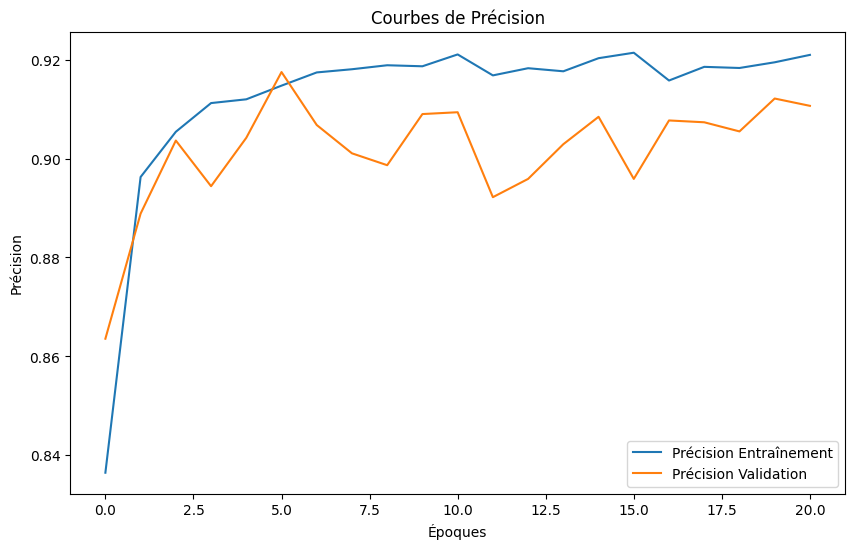

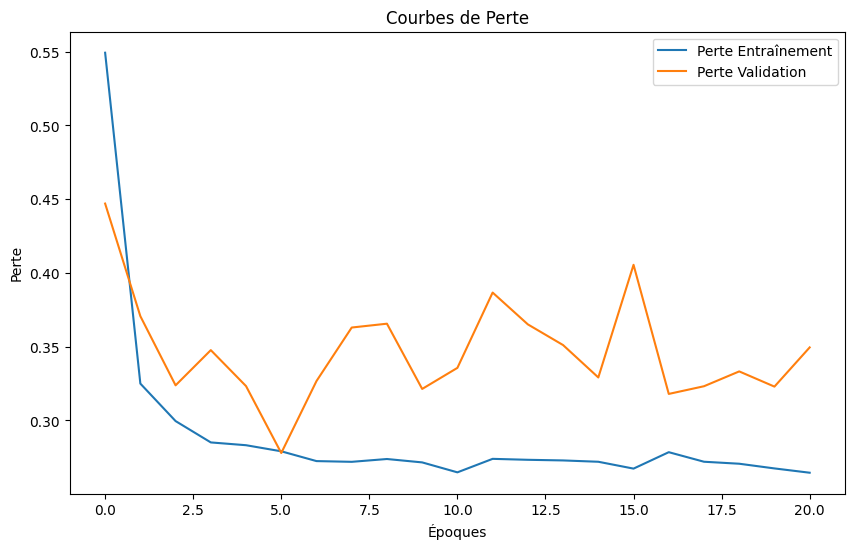

In [12]:
# Tracer les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(combined_history['accuracy'], label='Précision Entraînement')
plt.plot(combined_history['val_accuracy'], label='Précision Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.title('Courbes de Précision')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(combined_history['loss'], label='Perte Entraînement')
plt.plot(combined_history['val_loss'], label='Perte Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Courbes de Perte')
plt.show()

***ÉVALUATION DU MODÈLE ET AFFICHAGE DES RESULTATS***


In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)  # Évaluation sur l'ensemble de test
print(f'Loss: {test_loss}, Accuracy: {test_accuracy}')  # Afficher la perte et la précision

342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.9129 - loss: 0.3392
Loss: 0.3418606221675873, Accuracy: 0.9082249402999878


***PRÉDICTIONS ET RAPPORT DE CLASSIFICATION***



In [14]:
test_generator.reset()  # Réinitialiser le générateur pour éviter les doublons
predictions = model.predict(test_generator)  # Faire des prédictions sur l'ensemble de test
predicted_classes = np.argmax(predictions, axis=1)  # Obtenir les classes prédites
true_classes = test_generator.classes  # Obtenir les classes réelles
class_labels = list(test_generator.class_indices.keys())  # Étiquettes des classes

342/342 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step


In [15]:
# Rapport de classification
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Rapport de Classification:\n", report)

Rapport de Classification:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.83      0.87        63
                                 Apple___Black_rot       0.74      0.92      0.82        63
                          Apple___Cedar_apple_rust       0.93      0.96      0.95        28
                                   Apple___healthy       0.87      0.90      0.88       165
                               Blueberry___healthy       0.95      0.91      0.93       151
          Cherry_(including_sour)___Powdery_mildew       0.97      0.94      0.96       106
                 Cherry_(including_sour)___healthy       0.80      0.98      0.88        86
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.72      0.50      0.59        52
                       Corn_(maize)___Common_rust_       0.97      1.00      0.98       120
               Corn_(maize)___Northern_Leaf_Blight 

In [16]:
# Matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)  # Calculer la matrice de confusion

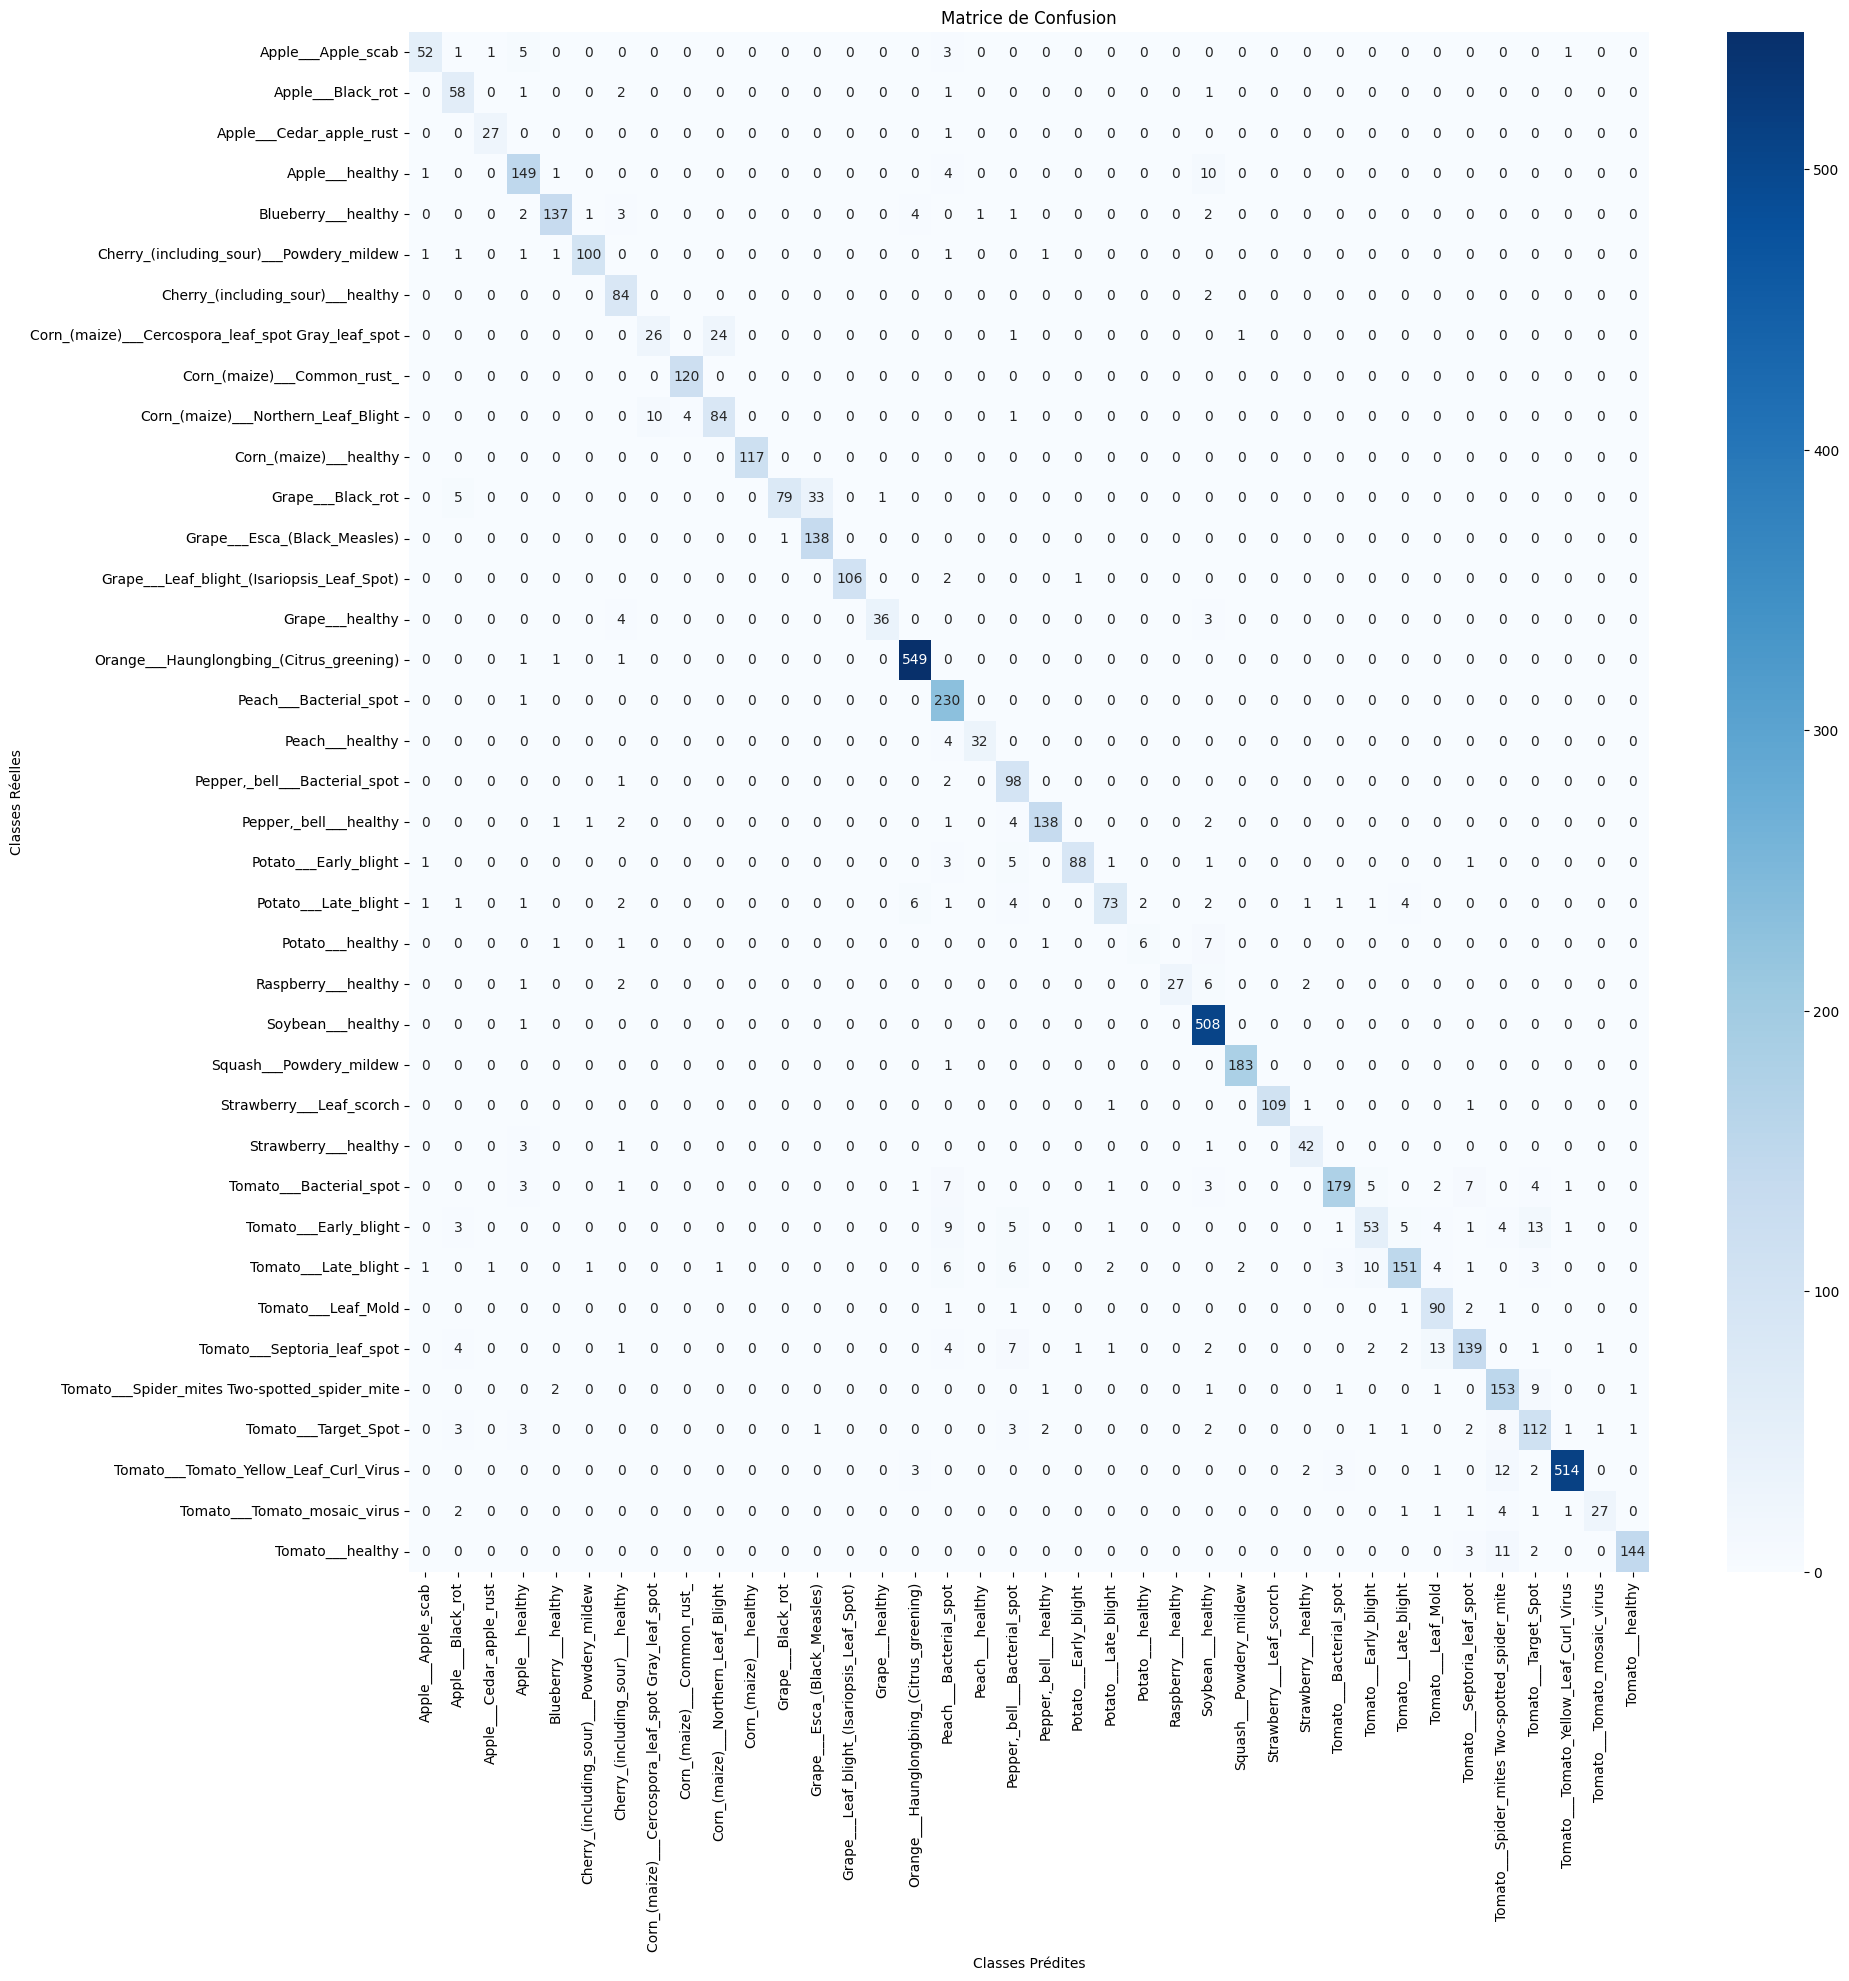

In [17]:
# Affichage de la matrice de confusion
plt.figure(figsize=(20, 20))  # Définir la taille de la figure
sns.heatmap(
    cm,
    annot=True,  # Ajouter les annotations sur la matrice
    fmt='d',  # Format entier
    cmap='Blues',  # Palette de couleurs bleues
    xticklabels=class_labels,  # Étiquettes des axes
    yticklabels=class_labels
)
plt.title("Matrice de Confusion")  # Titre du graphique
plt.ylabel("Classes Réelles")  # Légende de l'axe Y
plt.xlabel("Classes Prédites")  # Légende de l'axe X
plt.xticks(rotation=90)  # Rotation des étiquettes de l'axe X
plt.yticks(rotation=0)  # Pas de rotation pour l'axe Y
plt.show()  # Afficher la matrice

***VISUALISATION DES COURBES D'APPRENTISSAGE***


Bloc de fine-tuning 1 à 5
Epoch 1/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6700 - loss: 2.1851
Epoch 1: val_accuracy did not improve from 0.91748
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 631s 229ms/step - accuracy: 0.6701 - loss: 2.1847 - val_accuracy: 0.8900 - val_loss: 0.4840
Epoch 2/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8600 - loss: 0.5725
Epoch 2: val_accuracy did not improve from 0.91748
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 628s 231ms/step - accuracy: 0.8600 - loss: 0.5725 - val_accuracy: 0.9049 - val_loss: 0.4100
Epoch 3/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8862 - loss: 0.4318
Epoch 3: val_accuracy improved from 0.91748 to 0.92173, saving model to /content/drive/MyDrive/Data/Anas_Essai_1_MOB_Repeat.keras
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 622s 229ms/step - accuracy: 0.8862 - loss: 0.4318 - val_accuracy: 0.9217 - val_loss: 0.3208
Epoch 4/5
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9027 - loss: 0.3530
Epoch 4: val_accu

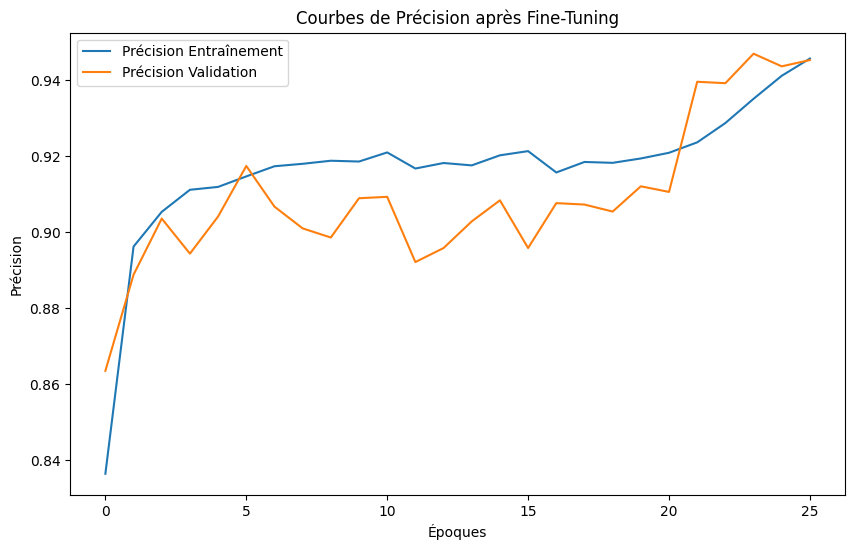

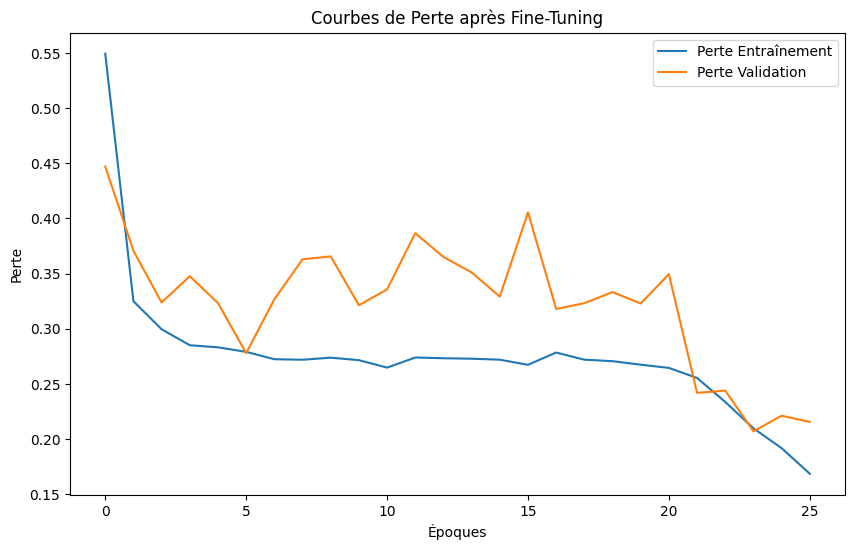

342/342 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.9519 - loss: 0.2287
Loss après fine-tuning: 0.2291291356086731, Accuracy après fine-tuning: 0.9446784853935242
342/342 ━━━━━━━━━━━━━━━━━━━━ 43s 120ms/step


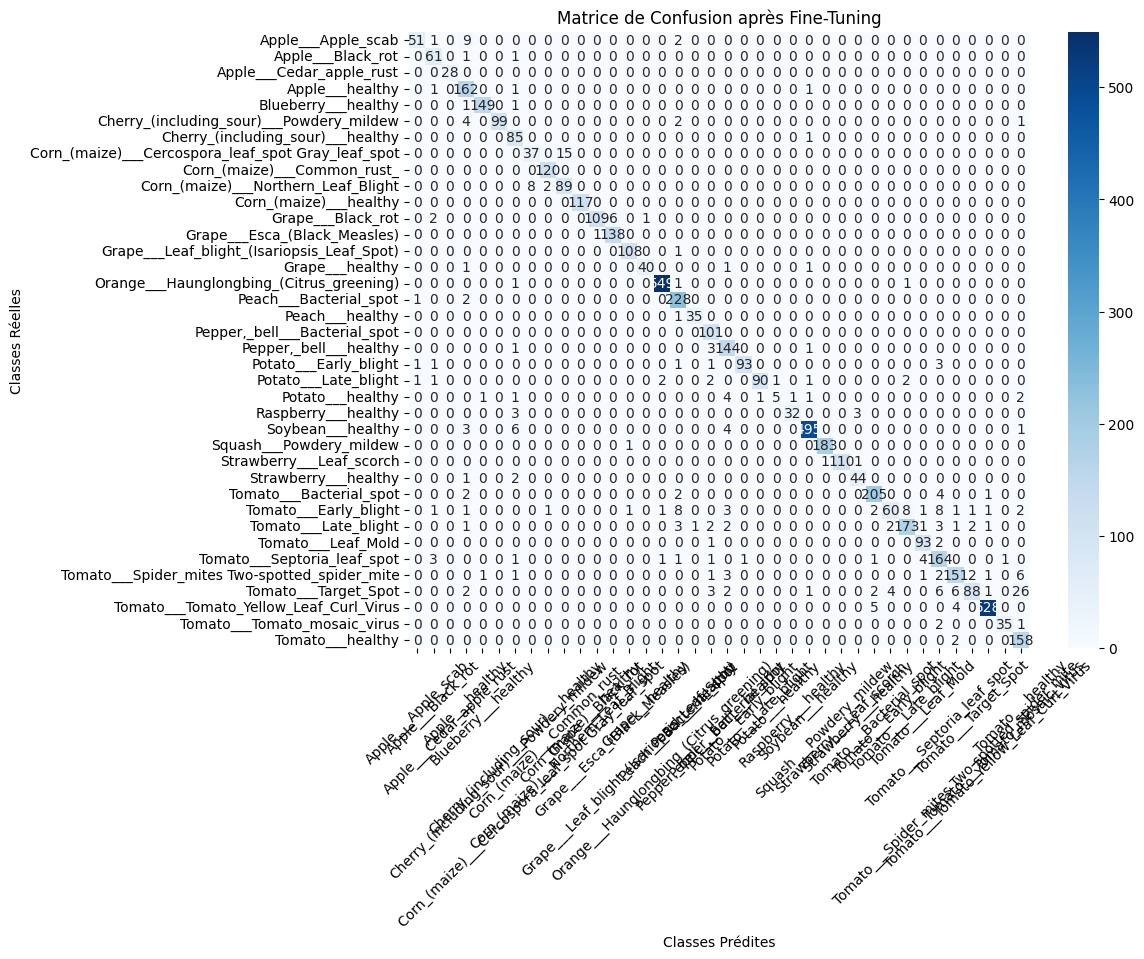

In [18]:
# ============================================
# FINE-TUNING DU MODÈLE PAR BLOCS
# ============================================
base_model.trainable = True  # Débloquer les couches pour le fine-tuning
for layer in base_model.layers[:-30]:  # Gèle toutes sauf les 30 dernières couches
    layer.trainable = False

# Recompiler le modèle avec un taux d'apprentissage plus faible
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Optimiseur Adam avec un taux d'apprentissage réduit
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10  # Nombre total d'époques pour le fine-tuning
block_size = 5  # Taille des blocs pour le fine-tuning

for i in range(0, fine_tune_epochs, block_size):
    start_epoch = i  # Début du bloc
    end_epoch = min(i + block_size, fine_tune_epochs)  # Fin du bloc
    print(f"Bloc de fine-tuning {start_epoch + 1} à {end_epoch}")
    fine_tune_history = model.fit(
        train_generator,
        epochs=end_epoch,
        initial_epoch=start_epoch,  # Assure que les époques ne redémarrent pas
        validation_data=val_generator,
        callbacks=[checkpoint_best, early_stopping],
        verbose=1
    )

    # Sauvegarde des poids après chaque bloc de fine-tuning
    model.save(f'/content/drive/MyDrive/Data/model_MOB_fine_tune_after_block_{start_epoch + 1}_{current_date}.keras')

# Vérifier si les données combinées existent pour éviter les conflits
data_keys = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
if not all(key in combined_history for key in data_keys):
    combined_history = {key: [] for key in data_keys}

# Tracer les courbes d'apprentissage après fine-tuning
fine_tune_combined_history = {
    'accuracy': combined_history['accuracy'] + fine_tune_history.history['accuracy'],
    'val_accuracy': combined_history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
    'loss': combined_history['loss'] + fine_tune_history.history['loss'],
    'val_loss': combined_history['val_loss'] + fine_tune_history.history['val_loss']
}

plt.figure(figsize=(10, 6))
plt.plot(fine_tune_combined_history['accuracy'], label='Précision Entraînement')
plt.plot(fine_tune_combined_history['val_accuracy'], label='Précision Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.title('Courbes de Précision après Fine-Tuning')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(fine_tune_combined_history['loss'], label='Perte Entraînement')
plt.plot(fine_tune_combined_history['val_loss'], label='Perte Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Courbes de Perte après Fine-Tuning')
plt.show()

# Évaluation globale sur l'ensemble de test après fine-tuning
test_loss_ft, test_accuracy_ft = model.evaluate(test_generator)  # Évaluation après fine-tuning
print(f'Loss après fine-tuning: {test_loss_ft}, Accuracy après fine-tuning: {test_accuracy_ft}')

# Prédictions après fine-tuning
fine_tune_predictions = model.predict(test_generator)
fine_tune_predicted_classes = np.argmax(fine_tune_predictions, axis=1)

# Matrice de confusion après fine-tuning
fine_tune_cm = confusion_matrix(true_classes, fine_tune_predicted_classes)

# Affichage de la matrice de confusion après fine-tuning
plt.figure(figsize=(10, 8))
sns.heatmap(fine_tune_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matrice de Confusion après Fine-Tuning")
plt.ylabel("Classes Réelles")
plt.xlabel("Classes Prédites")
plt.xticks(rotation=45)
plt.show()

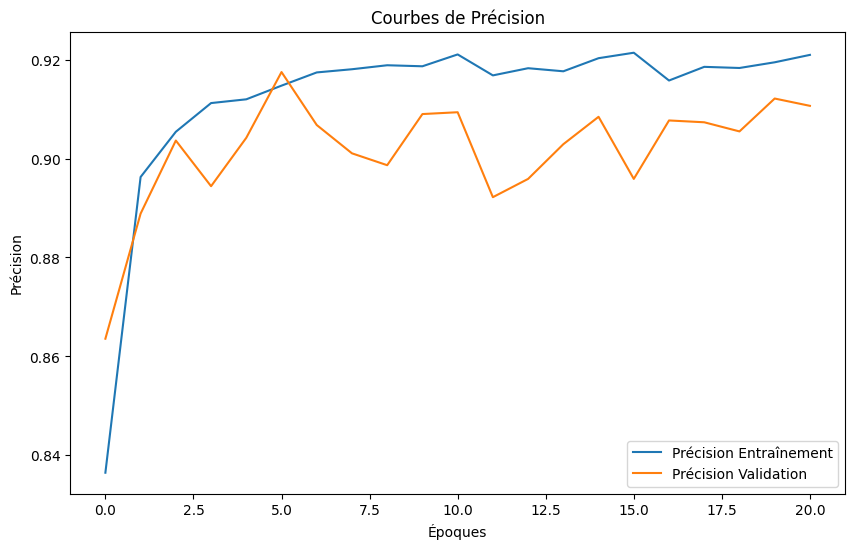

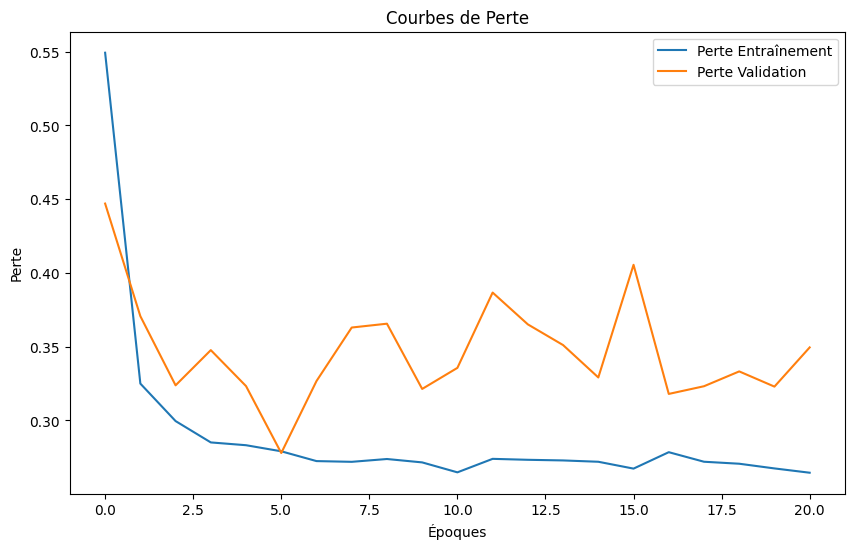

In [19]:
# ============================================
# TRACER LES COURBES D'APPRENTISSAGE
# ============================================
plt.figure(figsize=(10, 6))
plt.plot(combined_history['accuracy'], label='Précision Entraînement')
plt.plot(combined_history['val_accuracy'], label='Précision Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.title('Courbes de Précision')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(combined_history['loss'], label='Perte Entraînement')
plt.plot(combined_history['val_loss'], label='Perte Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Courbes de Perte')
plt.show()

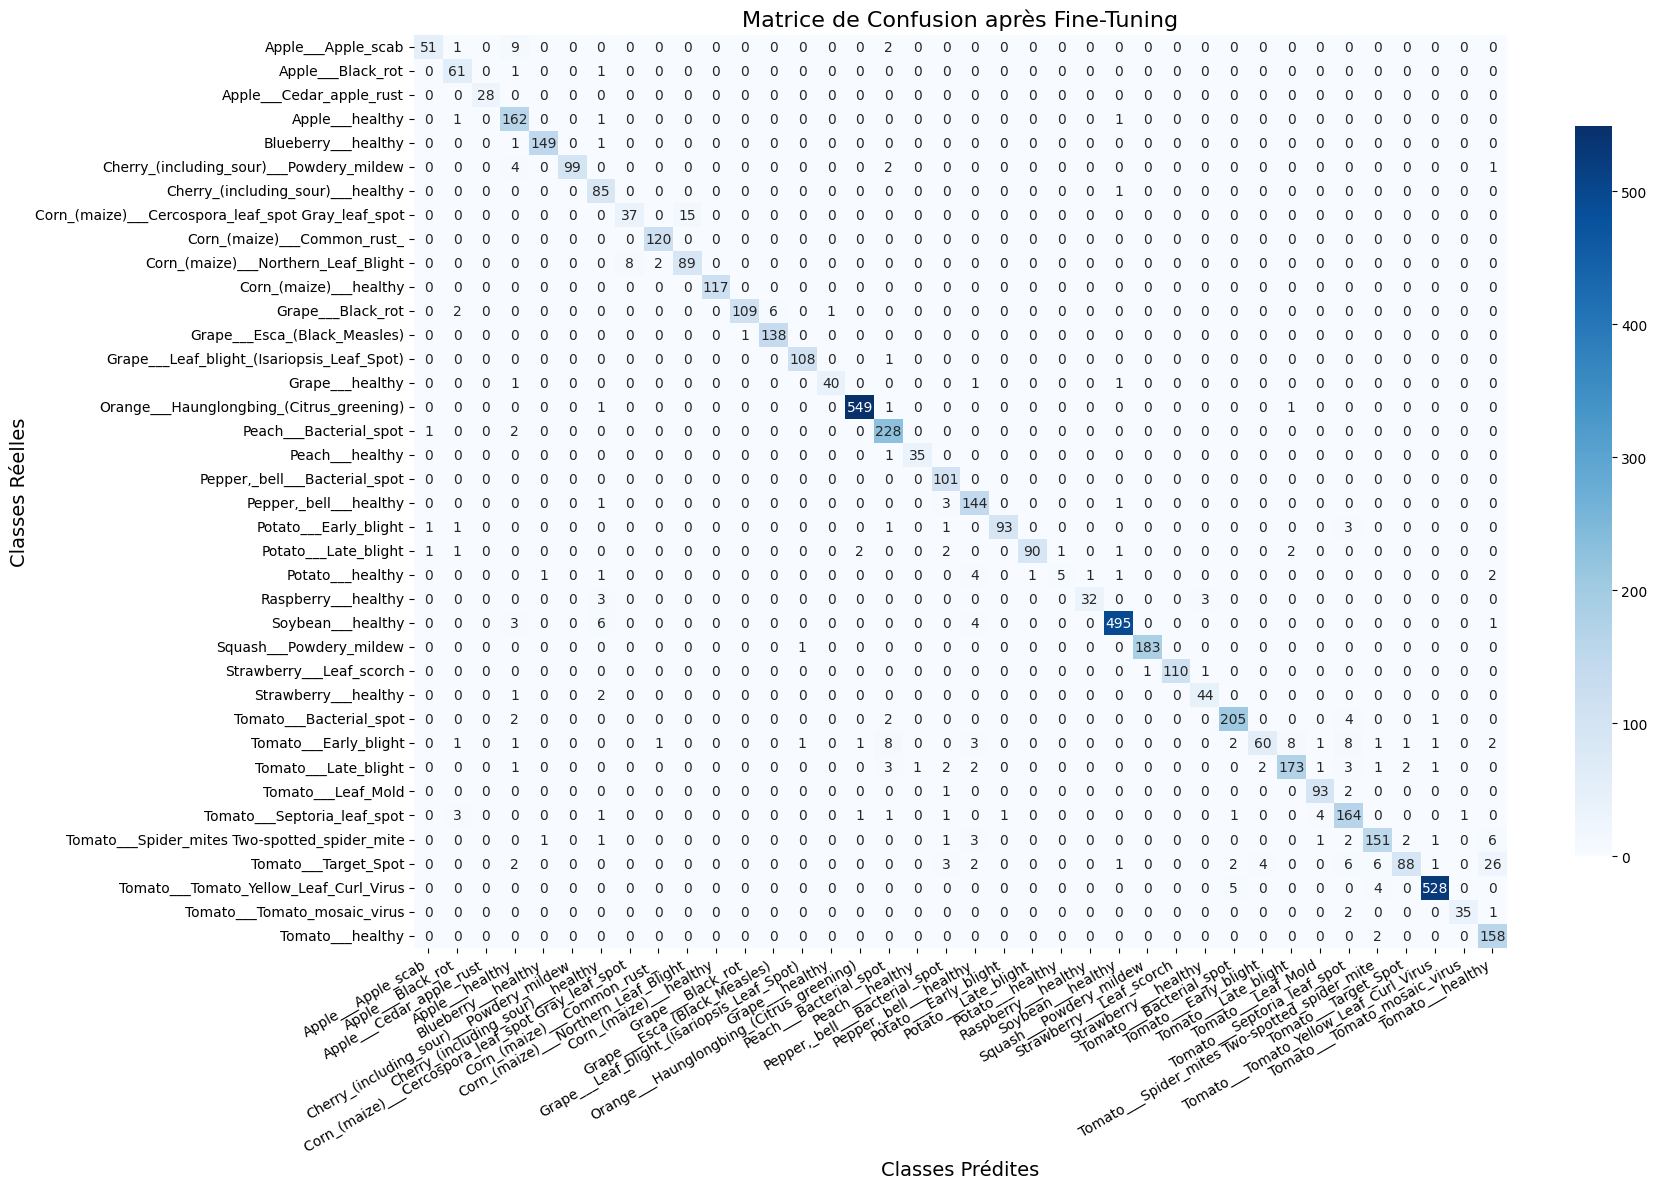

In [21]:
plt.figure(figsize=(18, 12))  # Augmenter la taille de la figure pour mieux espacer les étiquettes
sns.heatmap(
    fine_tune_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar_kws={'shrink': 0.8}  # Réduire la taille de la barre de couleur pour une meilleure présentation
)
plt.title("Matrice de Confusion après Fine-Tuning", fontsize=16)
plt.ylabel("Classes Réelles", fontsize=14)
plt.xlabel("Classes Prédites", fontsize=14)
plt.xticks(rotation=30, fontsize=10, ha='right')  # Rotation plus douce et alignement des étiquettes
plt.yticks(fontsize=10)  # Ajuster la taille des étiquettes de l'axe Y
plt.tight_layout()  # Ajuster automatiquement les éléments pour éviter le chevauchement
plt.show()
